**Objectif :** L'objectif principal de ce notebook est de préparer et d'analyser les données issus des images satellites dans le but de suivre l'évolution de l'indice de végétation.

**Travail :**
A partir des données brutes nous voulons créer les rasters, puis calculer et analyser l'indice de végétation pour chaque parcelle agricole d'une zone géographique donnée.

Les différentes actions et transformations réalisées ici sont les suivantes :
    
1. A partir des images brutes .jp2 convertir en .tif
2. Préparer les features : calculer le NDVI pour chaque parcelle a chaque date
3. Enregistrer le résultat sous format d'image .tif
4. Superposer un .shapefile (représentant des polygones de zone d'intérêt) et les images .tif des NDVI
5. Calculer des statistiques pour chaque polygone (ie. parcelle) de l'image
6. Créer des séries temporelles (en fonction d'une caractéristique par exemple la médiane des NDVI)

In [ ]:
student_folder = 'kattin_dassance'

# Import packages

In [ ]:
## Basics
import os
from os.path import isfile, isdir, join
from os import listdir
import subprocess
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import sys
import json
import plotly.express as px
from plotly.graph_objs import Scatter, Layout, Bar
from copy import deepcopy
import wget
# import shapely
# import warnings
# from shapely.errors import ShapelyDeprecationWarning
# from six.moves import range

## Geo
import tifffile as tiff
from osgeo import gdal
from rasterstats import zonal_stats
import geopandas as gpd

## SKlearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## XGBoost
from xgboost import XGBClassifier

## LSTM
from keras.models import Sequential
from keras.layers import Masking, Dropout, LSTM, Dense
from keras.losses import binary_crossentropy
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('CPU') # GPU
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Install packages

In [ ]:
# !pip install rasterstats

In [ ]:
# !pip install geopandas

In [ ]:
# !pip install wget

In [ ]:
# ! pip3 install xgboost==1.4.1

In [ ]:
# Installation de osgeo
# !pip install --global-option=build_ext --global-option='-I/usr/include/gdal' GDAL==`gdal-config --version`  

# Import data

---

🚨 ❗L'importation des données prend environ 15 minutes ❗

---

In [ ]:
url1 = 'https://ecoles-projets-shared-files.hupi.io/satellite/DSC.zip'
url2='https://ecoles-projets-shared-files.hupi.io/satellite/USE_CASE_1_correction.zip'
wget.download(url1)
wget.download(url2)

'USE_CASE_2.zip'

In [ ]:
ls

DSC/  DSC.zip  sample_data/  USE_CASE_1_correction.zip  USE_CASE_2.zip


In [ ]:
# !unzip DSC.zip
# !unzip USE_CASE_1_correction.zip

# Function definition
## Conversion d'un objet en une image 

- Input : une matrice.image de type `array`
- Output : une image sous format `.tif`
- Option : ajuster selon les propriétés d'une image de référence (une projection, le système de géoréférence)

In [ ]:
from osgeo import gdal,gdal_array,osr,ogr

def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == 'Byte':
        GDT_dtype = gdal.GDT_Byte
    elif dtype == 'Float32':
        GDT_dtype = gdal.GDT_Float32
    else:
        print('Not supported data type.')
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

# Path definition

In [ ]:
!mkdir ./etudiants/
!mkdir ./etudiants/$student_folder/
!mkdir ./etudiants/$student_folder/USE_CASE_1/
!mkdir ./etudiants/$student_folder/USE_CASE_1/output/
!mkdir ./etudiants/$student_folder/USE_CASE_1/NDVI/
!mkdir ./etudiants/$student_folder/USE_CASE_1/shp_stat/
!mkdir ./etudiants/$student_folder/USE_CASE_1/temporal_stats/
!mkdir ./etudiants/$student_folder/USE_CASE_1/cleaned_stats/
!mkdir ./etudiants/$student_folder/USE_CASE_1/reconstructed_stats/
!mkdir ./etudiants/$student_folder/USE_CASE_1/interpolated_stats/

In [ ]:
# Test
path = './DSC/'
output_path = './etudiants/'+student_folder+'/USE_CASE_1/output/'
ndvi_output_path = './etudiants/'+student_folder+'/USE_CASE_1/NDVI/'
stat_path = './etudiants/'+student_folder+'/USE_CASE_1/shp_stat/'
temporal_stats_path = './etudiants/'+student_folder+'/USE_CASE_1/temporal_stats/'

# Etape n°1 : convertir les images brutes en `.tif`

**Objectif :** prétraiter les données. Depuis un format compressé `.jp2` changer le format en `.tif`, en utilisant les commandes de la librairie `gdal`.

**Travail :** on va prétraiter les images satellites de résolution de 10 mètres.

**Les fonctions de `gdal` :**
- gdalwarp : permet de reprojecter une image
- gdal_translate : permet de convertir des données raster sous différents formats.

Exemple :
```
!/bin/bash
gdalwarp -lr 10 10 $1 $2
gdal_translate -unscale -ot Byte $2 $3
```

In [ ]:
# On filtre les données des images satellites, pour éviter de récolter des fichiers supplémentaires .txt par exemple
list_imgs = [name for name in listdir(path) if (isdir(join(path,name)) and 'SAFE' in name)]
print(list_imgs)

['S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.SAFE', 'S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.SAFE', 'S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.SAFE']


---

🚨 ❗Cette 1ère étape prend environ 10 minutes ❗

---

In [ ]:
def transform_jp2_to_tiff():
  ind = 0
  for img in list_imgs:
      
      ######       Etape 1 : transformer en .tif     ######
      
      img_path = join(path,img)
      
      # obtenir le dossier contenant les differentes images par bandes
      granule_path = join(img_path, 'GRANULE') # nom de dossier Granule fixe
      list_subdir = [name for name in listdir(granule_path) if isdir(join(granule_path, name))][0]
      band_path = join(granule_path, list_subdir, 'IMG_DATA')
      list_band_dir = [name for name in listdir(band_path) if isdir(join(band_path, name))]
      
      # obtenir la bande de résolution de 10m
      dir_10m = join(band_path, 'R10m')

      # filtrer les fichiers .xml ou tout fichier autre que .jp2 du dossier
      band_list = [name for name in listdir(join(dir_10m)) if isfile(join(dir_10m, name)) 
                  and len(name.split('.'))==2 and name.split('.')[1]=='jp2']
      
      # créer un dictionnaire avec le chemin de chaque bandes
      dict_bands = {}
      for band in band_list:
          tmp_path = join(dir_10m, band)

          # extension du nom de output est different de input : on recupere le nom et ajoute .tif
          name_band = band.split('.')[0]+'.tif'
          band_output_path = join(output_path, name_band)

          if band.split('_')[-2] == 'B04':
              dict_bands['red'] = band_output_path
          elif band.split('_')[-2] == 'B08':
              dict_bands['nir'] = band_output_path
          
          # convertir les données raster en format '.tif'
          # 'unscale' permet de ne pas perdre d'information spectrale
          subprocess.call(['gdal_translate', '-unscale', tmp_path, band_output_path])
        
        return(band_list)
    
transform_jp2_to_tiff()

In [ ]:
band_list

NameError: ignored

In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/output/

T31TCJ_20181117T105321_AOT_10m.tif  T31TCJ_20181127T105401_B08_10m.tif
T31TCJ_20181117T105321_B02_10m.tif  T31TCJ_20181127T105401_TCI_10m.tif
T31TCJ_20181117T105321_B03_10m.tif  T31TCJ_20181127T105401_WVP_10m.tif
T31TCJ_20181117T105321_B04_10m.tif  T31TCJ_20190103T104431_AOT_10m.tif
T31TCJ_20181117T105321_B08_10m.tif  T31TCJ_20190103T104431_B02_10m.tif
T31TCJ_20181117T105321_TCI_10m.tif  T31TCJ_20190103T104431_B03_10m.tif
T31TCJ_20181117T105321_WVP_10m.tif  T31TCJ_20190103T104431_B04_10m.tif
T31TCJ_20181127T105401_AOT_10m.tif  T31TCJ_20190103T104431_B08_10m.tif
T31TCJ_20181127T105401_B02_10m.tif  T31TCJ_20190103T104431_TCI_10m.tif
T31TCJ_20181127T105401_B03_10m.tif  T31TCJ_20190103T104431_WVP_10m.tif
T31TCJ_20181127T105401_B04_10m.tif


(10980, 10980)


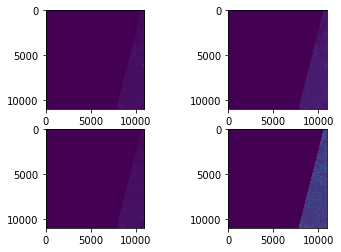

In [ ]:
bande_bleue = 'T31TCJ_20190103T104431_B02_10m.tif'
bande_verte = 'T31TCJ_20190103T104431_B03_10m.tif'
bande_rouge = 'T31TCJ_20190103T104431_B04_10m.tif'
bande_infra = 'T31TCJ_20190103T104431_B08_10m.tif'

print(tiff.imread(output_path + bande_bleue).shape)

fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(2, 2)

ax1.imshow(tiff.imread(output_path + bande_bleue))

ax2.imshow(tiff.imread(output_path + bande_verte))

ax3.imshow(tiff.imread(output_path + bande_rouge))

ax4.imshow(tiff.imread(output_path + bande_infra))

# Etape n°2 : extraire les caractéristiques

Il y a deux méthodes principales pour cela :
- Feature extraction : il faut la connaissance métier.
- Feature extraction avec ML : sans connaissances métiers.

Ici, nous allons tout d'abord travailler à partir d'une base de connaissance métier.

Notre objectif sera de prédire un indice de végétation, indiquant la nature d'une parcelle agricole.

**Indicateur métier :**

Définition [Indice de végétation] = c'est un indice entre 0 et 1 (ou -1 et 1) plus c'est proche de 1, plus la végétation est dense, importante. Cet indicateur est utilisé pour suivre les cultures d'hiver et d'été.

$$ NDVI = \frac{NIR - RED}{NIR + RED} $$

où $NIR$ est la réflexion mesurée dans le canal proche infrarouge (near infrared) et $RED$ est celle mesurée dans le canal rouge. 

In [ ]:
ls -altr ./etudiants/$student_folder/USE_CASE_1/

total 36
drwxr-xr-x 3 root root 4096 Jan 31 09:07 ../
drwxr-xr-x 2 root root 4096 Jan 31 09:07 NDVI/
drwxr-xr-x 2 root root 4096 Jan 31 09:07 shp_stat/
drwxr-xr-x 2 root root 4096 Jan 31 09:07 temporal_stats/
drwxr-xr-x 2 root root 4096 Jan 31 09:07 cleaned_stats/
drwxr-xr-x 2 root root 4096 Jan 31 09:07 reconstructed_stats/
drwxr-xr-x 2 root root 4096 Jan 31 09:07 interpolated_stats/
drwxr-xr-x 9 root root 4096 Jan 31 09:07 ./
drwxr-xr-x 2 root root 4096 Jan 31 09:13 output/


<ipython-input-32-1ba8986114f8>:44: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul


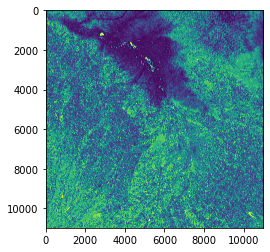

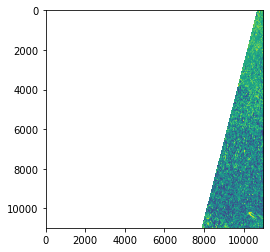

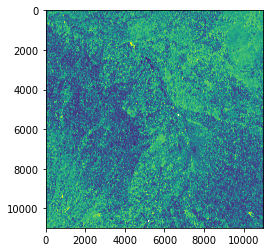

In [ ]:
def extract_ndvi_measures():
  ind = 0
  for img in list_imgs:
      
      ######       Etape 1 : transformer en .tif     ######
      
      img_path = join(path,img)
      
      # obtenir le dossier contenant les differentes images par bandes
      granule_path = join(img_path, 'GRANULE') # nom de dossier Granule fixe
      list_subdir = [name for name in listdir(granule_path) if isdir(join(granule_path, name))][0]
      band_path = join(granule_path, list_subdir, 'IMG_DATA')
      list_band_dir = [name for name in listdir(band_path) if isdir(join(band_path, name))]
      
      # obtenir la bande de résolution de 10m
      dir_10m = join(band_path, 'R10m')

      # filtrer les fichiers .xml ou tout fichier autre que .jp2 du dossier
      band_list = [name for name in listdir(join(dir_10m)) if isfile(join(dir_10m, name)) 
                  and len(name.split('.'))==2 and name.split('.')[1]=='jp2']
      
      # créer un dictionnaire avec le chemin de chaque bandes
      dict_bands = {}
      for band in band_list:
          tmp_path = join(dir_10m, band)

          # extension du nom de output est different de input : on recupere le nom et ajoute .tif
          name_band = band.split('.')[0]+'.tif'
          band_output_path = join(output_path, name_band)

          if band.split('_')[-2] == 'B04':
              dict_bands['red'] = band_output_path
          elif band.split('_')[-2] == 'B08':
              dict_bands['nir'] = band_output_path
          
          # convertir les données raster en format '.tif'
          # 'unscale' permet de ne pas perdre d'information spectrale
          # subprocess.call(['gdal_translate', '-unscale', tmp_path, band_output_path])
          
          
      ####          Etape 2 Features extraction     #####
      nir_band = tiff.imread(dict_bands['nir'])
      red_band = tiff.imread(dict_bands['red'])
      ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul
      ndvi[ndvi>1]=1
      plt.figure(ind)
      plt.imshow(ndvi)
      plt.show()
      ind+=1

extract_ndvi_measures()

# Etape n°3 : sauvegarder le résultat sous format `.tif` à l'aide de la fonction `array2raster`

In [ ]:
def save_ndvi_imgs():
  ind = 0
  for img in list_imgs:
      
      ######       Etape 1 : transformer en .tif     ######
      
      img_path = join(path,img)
      
      # obtenir le dossier contenant les differentes images par bandes
      granule_path = join(img_path, 'GRANULE') # nom de dossier Granule fixe
      list_subdir = [name for name in listdir(granule_path) if isdir(join(granule_path, name))][0]
      band_path = join(granule_path, list_subdir, 'IMG_DATA')
      list_band_dir = [name for name in listdir(band_path) if isdir(join(band_path, name))]
      
      # obtenir la bande de résolution de 10m
      dir_10m = join(band_path, 'R10m')

      # filtrer les fichiers .xml ou tout fichier autre que .jp2 du dossier
      band_list = [name for name in listdir(join(dir_10m)) if isfile(join(dir_10m, name)) 
                  and len(name.split('.'))==2 and name.split('.')[1]=='jp2']
      
      # créer un dictionnaire avec le chemin de chaque bandes
      dict_bands = {}
      for band in band_list:
          tmp_path = join(dir_10m, band)

          # extension du nom de output est different de input : on recupere le nom et ajoute .tif
          name_band = band.split('.')[0]+'.tif'
          band_output_path = join(output_path, name_band)

          if band.split('_')[-2] == 'B04':
              dict_bands['red'] = band_output_path
          elif band.split('_')[-2] == 'B08':
              dict_bands['nir'] = band_output_path
          
          # convertir les données raster en format '.tif'
          # 'unscale' permet de ne pas perdre d'information spectrale
          # subprocess.call(['gdal_translate', '-unscale', tmp_path, band_output_path])
          
          
      ####          Etape 2 : extraire le ndvi    #####
      nir_band = tiff.imread(dict_bands['nir'])
      red_band = tiff.imread(dict_bands['red'])
      ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul
      ndvi[ndvi>1]=1
      # plt.figure(ind)
      # plt.imshow(ndvi)
      # plt.show()
      # ind+=1

      #####       Etape 3 : enregistrer le resultat sous format .tif  ######
      name_f = img.split('.')[0]+'.tif'
      ndvi_output_raster = join(ndvi_output_path, name_f)

      # le ndvi fait 10m*10m
      dataset = gdal.Open(dict_bands['nir'])

      # sauvegarde
      array2raster(ndvi_output_raster, dataset, ndvi, 'Float32')

save_ndvi_imgs()

<ipython-input-33-5d23ca009b78>:44: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.divide((nir_band - red_band), (nir_band + red_band)) # + 0.0001 pour rendre le diviseur non nul


In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/NDVI/

S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.tif
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.tif
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.tif


# Conclusion temporaire :

Nous avons pour chaque image satellite, calculé l'indice de végétation associé. On a donc à chaque pixel donné, la valeur de l'indicateur NDVI.

Commençons par découvrir et analyser cet indicateur sur des parcelles agricoles pré-définies. En effet, nous avons à notre disposition un fichier sous format de .shapefile, représentant des polygones définissant des parcelles agricoles spécifiques.

L'objectif de la découverte des données est de calculer des statistiques de l'indice NDVI sur ces parcelles agricoles.

# Etape n°4 : calculer des statistiques

A partir du fichier `.shp`, on va calculer sur chaque polygone des statistiques de l'indice NDVI : 
- la moyenne sur les ? jours étudiées
- la médiane
- le minimum et le maximum

Pour cela on va utiliser la librairie `rasterstats` qui permet à partir d'un raster et d'un shapefile calculer des statistiques.


In [ ]:
ndvi_list = [name for name in listdir(ndvi_output_path) if isfile(join(ndvi_output_path, name))]
print(np.array(ndvi_list))

['S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.tif'
 'S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.tif'
 'S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.tif']


In [ ]:
!ls ./DSC/shapefile

T31TCJ_MIS_BTH.cpg  T31TCJ_MIS_BTH.prj	T31TCJ_MIS_BTH.shx
T31TCJ_MIS_BTH.dbf  T31TCJ_MIS_BTH.shp


In [ ]:
def compute_statistics_from_ndvi():
  warnings.filterwarnings('ignore', category=ShapelyDeprecationWarning) 
  shp_file = './DSC/shapefile/T31TCJ_MIS_BTH.shp'
  for ndvi_img in ndvi_list:
      ndvi_img_path = join(ndvi_output_path, ndvi_img)
      zone_f = zonal_stats(shp_file, ndvi_img_path,
                          stats=['min', 'max', 'median', 'mean', 'std'],
                          nodata=np.nan,
                          copy_properties=True,
                          geojson_out=True)
      # chaque dictionnaire est associe a une parcelle
      
      # sauvegarde en format geo dataframe
      geostats = gpd.GeoDataFrame.from_features(zone_f)
      geostats.crs = 'epsg:32631' # definir la projection
      output_file = join(stat_path, ndvi_img.split('.')[0]+'.shp')
      geostats.to_file(output_file)

compute_statistics_from_ndvi()

In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/shp_stat/

S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.cpg
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.dbf
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.prj
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shx
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.cpg
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.dbf
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.prj
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shp
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shx
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.cpg
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.dbf
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.prj
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shp
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shx


---

Exemple de statistiques le 17-11-2018 sur toutes les zones géographiques visées : 

---

In [ ]:
url = './etudiants/'+student_folder+'/USE_CASE_1/shp_stat/S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp'
geostats_test = gpd.read_file(url)

In [ ]:
geostats_test.head()

,fid,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,area,min,max,mean,std,median,CULTURE_D1,CULTURE_D2,geometry
0,7163652.0,3254775,17.93,MIS,2,179308.512395,0.121659,0.770717,0.254383,0.115304,0.216000,NaN,NaN,"POLYGON ((319536.462 4867103.915, 319867.231 4..."
1,7913374.0,12244663,5.72,MIS,2,57181.902327,0.072581,0.650523,0.179258,0.085530,0.146260,NaN,NaN,"POLYGON ((329673.499 4850161.704, 329665.546 4..."
2,7804707.0,11239602,5.48,MIS,2,54755.127837,0.144475,0.744256,0.281337,0.127953,0.229947,NaN,NaN,"POLYGON ((399215.319 4829801.046, 399205.640 4..."
3,7047346.0,3148886,22.76,MIS,2,227436.221611,0.032086,0.654779,0.103146,0.089812,0.077619,NaN,NaN,"POLYGON ((361120.600 4850919.265, 361120.585 4..."
4,7829266.0,8481604,6.04,MIS,2,60333.785977,0.134348,0.701759,0.244950,0.104065,0.203579,NaN,NaN,"POLYGON ((403011.425 4837089.559, 403003.095 4..."


In [ ]:
geostats_test.columns

Index(['fid', 'ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP', 'area',
       'min', 'max', 'mean', 'std', 'median', 'CULTURE_D1', 'CULTURE_D2',
       'geometry'],
      dtype='object')

# Etape n°5 : créer une série temporelle

On va traiter chaque mesure d'une parcelle, comme une série temporelle. L'objectif sera de faire des statistiques sur ces séries temporelles.

In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/shp_stat/

S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.cpg
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.dbf
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.prj
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp
S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shx
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.cpg
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.dbf
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.prj
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shp
S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shx
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.cpg
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.dbf
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.prj
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shp
S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shx


In [ ]:
def construct_temporal_stats(stat_path,output_path):
    vi_list = ['ndvi']
    all_stats = ['mean','median','std','min','max']
    stat_list = ['median']
    list_imgs = [name for name in listdir(stat_path) if isfile(join(stat_path,name)) and name.split('.')[1]=='shp']
    # on ordonne par date
    list_imgs = sorted(list_imgs, key=lambda x: int(x.split('_')[2][0:8]))
    
    # en boucle sur chaque image
    for vi in vi_list:
        for stat in stat_list:
            cnt = 0
            for img in list_imgs:
                print ('CONSTRUCTING TEMPORAL STATS FOR %s and %s and %s'%(vi,stat,img))
                date = img.split('_')[2][0:8]
                shp_path = join(stat_path,img)
                gdf = gpd.read_file(shp_path)
                
                if cnt == 0:
                    new_gdf = gdf.copy()
                    new_gdf[date] = gdf[stat]
                    new_gdf.drop(all_stats,axis=1,inplace=True)
                else:
                    new_gdf[date] = gdf[stat]
                cnt+=1
            shp_output_path = join(output_path,'T31TCJ_'+vi+'_'+stat+'.shp')
            new_gdf.to_file(shp_output_path)     

__name__ = '__main__'
if __name__ == '__main__':
    construct_temporal_stats(stat_path, temporal_stats_path)

CONSTRUCTING TEMPORAL STATS FOR ndvi and median and S2A_MSIL2A_20181117T105321_N0210_R051_T31TCJ_20181117T121932.shp
CONSTRUCTING TEMPORAL STATS FOR ndvi and median and S2A_MSIL2A_20181127T105401_N0211_R051_T31TCJ_20181127T121653.shp
CONSTRUCTING TEMPORAL STATS FOR ndvi and median and S2A_MSIL2A_20190103T104431_N0211_R008_T31TCJ_20190103T112454.shp


In [ ]:
ls ./etudiants/$student_folder/USE_CASE_1/temporal_stats/

T31TCJ_ndvi_median.cpg  T31TCJ_ndvi_median.prj  T31TCJ_ndvi_median.shx
T31TCJ_ndvi_median.dbf  T31TCJ_ndvi_median.shp


In [ ]:
ls USE_CASE_1_correction/temporal_stats_prof/temporal_stats_prof

ls: cannot access 'USE_CASE_1_correction/temporal_stats_prof/temporal_stats_prof': No such file or directory


In [ ]:
url = './USE_CASE_1_correction/temporal_stats_prof/T31TCJ_ndvi_median.shp'
time_serie = gpd.read_file(url)

In [ ]:
time_serie.head()

,fid,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP,CULTURE_D1,CULTURE_D2,area,20181112,20181115,...,20190906,20190913,20190915,20190916,20190920,20190921,20191008,20191011,20191013,geometry
0,7918132.0,8583490,2.71,MIS,2,None,None,27085.062805,0.225880,NaN,...,NaN,0.327259,NaN,NaN,NaN,NaN,0.211341,NaN,0.199078,"POLYGON ((346100.728 4856718.116, 346101.164 4..."
1,7109780.0,14712598,2.60,MIS,2,None,None,25972.267365,0.305204,NaN,...,NaN,0.865731,NaN,NaN,NaN,NaN,0.606084,NaN,0.436044,"POLYGON ((388836.372 4848383.454, 388836.586 4..."
2,7021173.0,12205360,5.57,MIS,2,None,None,55591.881784,0.223748,NaN,...,NaN,0.822231,NaN,NaN,NaN,NaN,0.509181,NaN,0.423261,"POLYGON ((317915.388 4796580.085, 317910.352 4..."
3,7891909.0,16205895,5.00,MIS,2,None,None,49999.741512,0.165396,NaN,...,NaN,0.534748,0.433435,NaN,0.326007,NaN,0.203958,NaN,0.197751,"POLYGON ((404297.751 4848228.615, 404328.793 4..."
4,695973.0,16183747,4.25,MIS,2,DFV,DVS,42492.768066,0.220622,NaN,...,NaN,0.798481,0.694769,NaN,0.658811,NaN,0.450977,NaN,0.406509,"POLYGON ((393371.402 4844649.750, 393322.862 4..."


# TP 1 : Inspect temporal stats

## Load the geodataframe
Le même travail a été réalisé avec un plus grand nombre d'images satellites, à partir du `12-11-2018` au `13-10-2019` (66 dates). On a donc presque 1 an de données de indicateur de végétation pour chaque parcelle du shapefile observée.

In [ ]:
url = './USE_CASE_1_correction/temporal_stats_prof/T31TCJ_ndvi_median.shp'
gdf_ndvi = gpd.read_file(url)

print('Informations :')
print(type(gdf_ndvi))
print(gdf_ndvi.shape)

Informations :
<class 'geopandas.geodataframe.GeoDataFrame'>
(5000, 75)


In [ ]:
gdf_ndvi.iloc[:,0:5]

,fid,ID_PARCEL,SURF_PARC,CODE_CULTU,CODE_GROUP
0,7918132.0,8583490,2.71,MIS,2
1,7109780.0,14712598,2.60,MIS,2
2,7021173.0,12205360,5.57,MIS,2
3,7891909.0,16205895,5.00,MIS,2
4,695973.0,16183747,4.25,MIS,2
...,...,...,...,...,...
4995,7866928.0,16178895,2.50,BTH,1
4996,7043233.0,3150954,7.62,BTH,1
4997,7951143.0,8545608,6.90,BTH,1
4998,7219111.0,10062551,15.74,BTH,1


In [ ]:
gdf_ndvi.iloc[:,5:15]

,CULTURE_D1,CULTURE_D2,area,20181112,20181115,20181117,20181125,20181127,20181219,20190103
0,NaN,NaN,27085.062805,0.225880,NaN,0.402877,NaN,0.651829,NaN,NaN
1,NaN,NaN,25972.267365,0.305204,NaN,0.325589,NaN,0.366240,NaN,NaN
2,NaN,NaN,55591.881784,0.223748,NaN,0.237835,NaN,0.322333,NaN,NaN
3,NaN,NaN,49999.741512,0.165396,NaN,0.192027,NaN,0.201810,0.224843,0.304677
4,DFV,DVS,42492.768066,0.220622,NaN,0.248052,NaN,0.281957,0.436703,0.512927
...,...,...,...,...,...,...,...,...,...,...
4995,NaN,NaN,25009.197594,0.115875,NaN,0.146863,NaN,0.202459,0.370068,0.483932
4996,NaN,NaN,76108.772327,0.148536,NaN,0.208777,NaN,0.324335,0.662269,0.812591
4997,NaN,NaN,69007.675065,0.104522,NaN,0.162730,NaN,0.238011,NaN,NaN
4998,NaN,NaN,157208.368362,0.116782,NaN,0.118851,NaN,0.113749,NaN,NaN


## 🌴 Analyse 1 :
---

Count nans in each column in the geodataframe and create a dataframe where we count the number of nans for each date.

In [ ]:
cols = gdf_ndvi.columns
cols

Index(['fid', 'ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP',
       'CULTURE_D1', 'CULTURE_D2', 'area', '20181112', '20181115', '20181117',
       '20181125', '20181127', '20181219', '20190103', '20190109', '20190111',
       '20190116', '20190203', '20190212', '20190213', '20190215', '20190217',
       '20190218', '20190220', '20190222', '20190223', '20190225', '20190227',
       '20190320', '20190322', '20190324', '20190325', '20190327', '20190329',
       '20190330', '20190409', '20190413', '20190419', '20190501', '20190513',
       '20190514', '20190531', '20190602', '20190608', '20190617', '20190618',
       '20190627', '20190703', '20190705', '20190708', '20190710', '20190712',
       '20190713', '20190715', '20190723', '20190725', '20190802', '20190804',
       '20190809', '20190814', '20190816', '20190817', '20190822', '20190824',
       '20190906', '20190913', '20190915', '20190916', '20190920', '20190921',
       '20191008', '20191011', '20191013', 'geometry'],
      d

In [ ]:
count_nan = gdf_ndvi[cols[8:-1]].isna().sum().values
print('NA (%) :', round(count_nan.sum()/(gdf_ndvi.shape[0]*(gdf_ndvi.shape[1]-9))*100, 2))
count_not_nan = list(len(gdf_ndvi)-count_nan)
count_nan = list(count_nan)

# Selection des dates et reformater
dates = list(cols[8:-1])+list(cols[8:-1])
dates = [x[0:4]+'-'+x[4:6]+'-'+x[6:] for x in dates]
date = [datetime.strptime(x,'%Y-%m-%d') for x in dates]

# Mise en forme
counts = count_nan+count_not_nan
types = ['nan' for i in range (0,int(len(dates)/2))] + ['not_nan' for i in range (0,int(len(dates)/2))]  
nan_df = pd.DataFrame(columns=['date','type','count'])
nan_df['date'] = dates
nan_df['type'] = types
nan_df['count'] = counts

NA (%) : 62.18


In [ ]:
nan_df.loc[nan_df['date']=='2018-11-12']

,date,type,count
0,2018-11-12,nan,117
66,2018-11-12,not_nan,4883


## ✋ Question 1 : 
Pour quelle raison on pourrait avoir autant de valeurs manquantes selon chaque date ?

Réponse : 




## 🌴  Analyse 2 : 

---

Use Plotly to create a bar plot. On the x-axis we have the dates and on the y-axis we have the counts of nans and not nans

And delete some dates.

In [ ]:
fig = px.bar(nan_df, x='date', y='count', color='type', height=400, title='NaN distribution on dates')
fig.show()

In [ ]:
# nan_df.loc[nan_df.type=='not_nan'].sort_values('count', ascending=True).plot(kind='barh', figsize=(16, 30), y='count')

Get dates that have more than 60% of missing data and drop them from the geodataframe

In [ ]:
tmp_df = nan_df.loc[(nan_df['type']=='nan')]
dates = tmp_df.loc[tmp_df['count']>=int(0.6*len(gdf_ndvi))]['date']
dates = [''.join(x.split('-')) for x in dates]

# on garde uniquement les dates pour les quelles le nb de valeur nulle est inférieur à 3000=0.6*len(gdf_ndvi)
cleaned_gdf = gdf_ndvi.drop(dates,axis=1)
cleaned_cols = cleaned_gdf.columns

print(cleaned_cols)

Index(['fid', 'ID_PARCEL', 'SURF_PARC', 'CODE_CULTU', 'CODE_GROUP',
       'CULTURE_D1', 'CULTURE_D2', 'area', '20181112', '20181117', '20181127',
       '20190111', '20190116', '20190215', '20190220', '20190225', '20190322',
       '20190327', '20190501', '20190531', '20190705', '20190710', '20190715',
       '20190725', '20190804', '20190809', '20190814', '20190824', '20190913',
       '20191008', '20191013', 'geometry'],
      dtype='object')


Count how many NA values remaining.

In [ ]:
np.isnan(cleaned_gdf[cleaned_cols[8:-1]].values).sum()

2956

In [ ]:
dates = list(cleaned_cols[8:-1].values)
dates = [x[0:4]+'-'+x[4:6]+'-'+x[6:] for x in dates]
date = [datetime.strptime(x,'%Y-%m-%d') for x in dates]

idx = 3
y_missing = list(cleaned_gdf.iloc[idx][cleaned_cols[8:-1]].values)

px.line(x=dates, y=y_missing, title='Median NDVI for one parcel')

In [ ]:
cleaned_stats = './etudiants/'+student_folder+'/USE_CASE_1/cleaned_stats/T31TCJ_median_ndvi.shp'
cleaned_gdf.to_file(cleaned_stats)

## 🖍 Exercice 1 :
---

### Missing data interpolation with Geopandas

A partir du tableau `cleaned_gdf` appliquer une interpolation linéaire afin d'estimer les valeurs manquantes. 

Rechercher la fonction dans la librairie `Geopandas`de Python.

Comparer et documenter différentes méthodes d'interpolation :
- linéaire,
- polynomiale,
- spline (une fonction polynomiale par morceaux),
- cubic (cas particulier de polynôme d'ordre 3)

In [ ]:
## A vous de jouer !


---

Une correction

In [ ]:
interpolated_gdf = cleaned_gdf.copy()
interpolated_gdf[cleaned_cols[8:-1]] = interpolated_gdf[cleaned_cols[8:-1]].interpolate(method='linear')
print('NA values =', np.isnan(interpolated_gdf[cleaned_cols[8:-1]].values).sum())

NA values = 0


In [ ]:
idx = 6
y_missing = list(cleaned_gdf.iloc[idx][cleaned_cols[8:-1]].values)
y_interpolated =list(interpolated_gdf.iloc[idx][cleaned_cols[8:-1]].values)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Scatter(
     x=dates,
     y=y_missing,
     name='missing data',
     marker=dict(
         color='blue'
               ),
     mode = 'lines')
trace2 = go.Scatter(
     x=dates,
     y=y_interpolated,
     name='filled data',
     marker=dict(
         color='red'
               ),
     mode = 'lines')

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 1000)
fig

## 🌴 Analyse 3  : Une méthode gagnante `Missing data reconstruction with KNN`
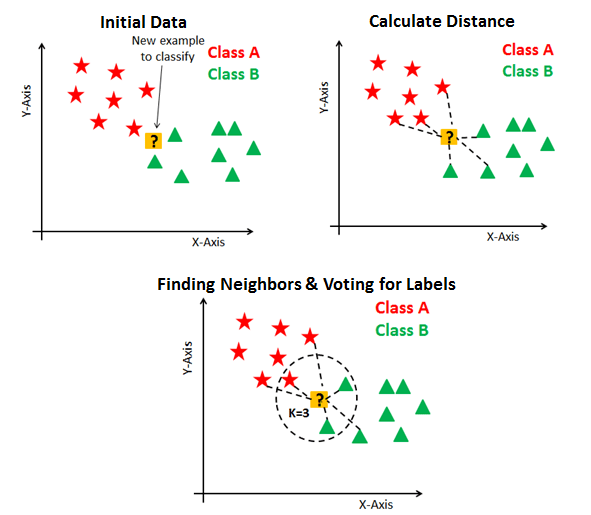

## ✋ Question 2 : 
Qu'est-ce que l'algorithme KNN ?

Réponse : 

In [ ]:
def pair_n_distance(X):
    n_rows, n_cols = X.shape
    D = np.ones((n_rows, n_rows), dtype='float32', order='C') * np.inf
    observed_features = np.isfinite(X).astype(int)
    n_common_features_observations = np.dot(observed_features,observed_features.T)
    actual_n_common_features = n_common_features_observations == 0
    n_no_common_observations = actual_n_common_features.sum(axis=1)
    observation_overlaps_all = (n_no_common_observations == 0)
    observation_overlaps_non = n_no_common_observations == n_rows
    diffs = np.zeros_like(X)
    missing_differences = np.zeros_like(diffs, dtype=bool)
    valid_observations = np.zeros(n_rows, dtype=bool)
    ssd = np.zeros(n_rows, dtype=X.dtype)

    for i in range(n_rows):
        if observation_overlaps_non[i]:
            continue
        x = X[i, :]
        np.subtract(X, x.reshape((1, n_cols)), out=diffs)
        np.isnan(diffs, out=missing_differences)
        diffs[missing_differences] = 0
        diffs **= 2
        observed_counts_per_observation = n_common_features_observations[i]
        if observation_overlaps_all[i]:
            diffs.sum(axis=1, out=D[i, :])
            D[i, :] /= observed_counts_per_observation
        else:
            np.logical_not(actual_n_common_features[i], out=valid_observations)
            diffs.sum(axis=1, out=ssd)
            ssd[valid_observations] /= observed_counts_per_observation[valid_observations]
            D[i, valid_observations] = ssd[valid_observations]
    return D

def init_knn(X, missing_mask):
    X_input = X.copy('C')
    if missing_mask.sum() != np.isnan(X_input).sum(): 
        X_input[missing_mask] = np.nan
    D = pair_n_distance(X_input)
    for i in range(X.shape[0]):
        D[i, i] = np.inf
    return X_input, D

def knn_reconstruct(X, missing_mask, k):
    n_rows, n_cols = X.shape
    X_output, D = init_knn(X, missing_mask)
    fin_distance_mask = np.isfinite(D)
    eff_inf = 10 ** 6 * D[fin_distance_mask].max()
    D[~fin_distance_mask] = eff_inf
    for i in range(n_rows):
        for j in np.where(missing_mask[i, :])[0]:
            distances = D[i, :].copy()
            distances[missing_mask[:, j]] = eff_inf
            ind_neighbors = np.argsort(distances)
            dist_neighbors = distances[ind_neighbors]
            valid_distances = dist_neighbors < eff_inf
            dist_neighbors = dist_neighbors[valid_distances][:k]
            ind_neighbors = ind_neighbors[valid_distances][:k]
            weights = 1.0 / dist_neighbors
            weight_sum = weights.sum()
            if weight_sum > 0:
                column = X[:, j]
                values = column[ind_neighbors]
                X_output[i, j] = np.dot(values, weights) / weight_sum
    return X_output

Réponse :

a) Afin de déterminer quels points de données sont les plus proches d'un point de requête donné, il faut d'abord calculer la distance euclidienne entre chaque paire de points. Pour cela, on sélectionne uniquement les données (sans valeurs manquantes) pour lesquelles on peut calculer des distances. Fonction : pair_n_distance.

b) Pour initialiser la matrice d'entrée de l'algorithme, il suffit de calculer toutes les distances. Fonction : init_knn.

c) On conserve ensuite les k observations du jeu de données qui sont les plus "proches" de l'observation à prédire. Si on effectue une régression, on calcule la moyenne des k observations retenues. Fonction : knn_reconstruct.

In [ ]:
reconstructed_gdf = cleaned_gdf.copy()
data_arr = reconstructed_gdf[cleaned_cols[8:-1]].values
missing_mask = np.isnan(data_arr)
rec_arr = knn_reconstruct(data_arr, missing_mask, 5) # on choisit les 5 plus proches voisins
reconstructed_gdf[cleaned_cols[8:-1]] = np.copy(rec_arr)

In [ ]:
ls -altr ./USE_CASE_1_correction/

total 20
drwxrwxr-x 2 root root 4096 Jan  4  2022 temporal_stats_prof/
drwxr-xr-x 3 root root 4096 Jan 20 09:33 ./
-rw-r--r-- 1 root root 6148 Jan 20 09:33 .DS_Store
drwxr-xr-x 1 root root 4096 Jan 31 09:07 ../


In [ ]:
# Save data as a geodataframe
reconstructed_stats = './etudiants/'+student_folder+'/USE_CASE_1/reconstructed_stats/T31TCJ_median_ndvi.shp'
reconstructed_gdf.to_file(reconstructed_stats)

In [ ]:
idx = 6
y_missing = list(cleaned_gdf.iloc[idx][cleaned_cols[8:-1]].values)
y_interpolated =list(interpolated_gdf.iloc[idx][cleaned_cols[8:-1]].values)
y_reconstructed = list(reconstructed_gdf.iloc[idx][cleaned_cols[8:-1]].values)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Scatter(
     x=dates,
     y=y_missing,
     name='missing data',
     marker=dict(
         color='blue'
               ),
     mode = 'lines'
)
trace2 = go.Scatter(
     x=dates,
     y=y_interpolated,
     name='Interpolation',
     marker=dict(
         color='red'
               ),
     mode = 'lines'
)

trace3 = go.Scatter(
     x=dates,
     y=y_reconstructed,
     name='KNN',
     marker=dict(
         color='green'
               ),
     mode = 'lines'
)

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig.add_trace(trace3,secondary_y=True)
fig['layout'].update(height = 600, width = 1000)
fig

## 🖍 Exercice 2 :
---

### Missing data reconstruction with KNN algorithm

A partir du tableau `cleaned_gdf` appliquer un algorithme de KNN avec variation du nombre de voisins, à l'aide des librairies de sklearn.

In [ ]:
## A vous de jouer !

# TP 2 : Unsupervised Learning

## <u> Objectifs : </u>
## - A partir de l'indice de végétation, peut-on prédire la classe de végétation de chaque parcelle ? 
## - Evaluer les modèles non supervisés.

L'objectif de ce notebook est de rassembler des techniques d'analyse non supervisé des données.
Les algorithmes étudiées sont les suivants :

- ACP
- KMeans
- Variational AutoEncoder

En exercice vous serez amené à réaliser une ACP et un KMeans.

L'objectif technique : 

## 🌴  Analyse 4  : Reconstructed data histogram

- Groupe 1 = le blé
- Groupe 2 = le mais

Visualisation la différence entre les différentes parcelles agricoles selon leur indicateur de réflectance mesuré depuis les satellites et ensuite transformées et préparées avec des méthodes statistiques.

In [ ]:
fig = px.histogram(reconstructed_gdf, x='20190327',color='CODE_GROUP', nbins=10)
fig.show()

## ✋ Question 3 : 
Quelle observation peut-on en déduire ? Quel indice est plus élevé en été ?

Réponse :

## 🌴  Analyse 5  : Plot shapefiles

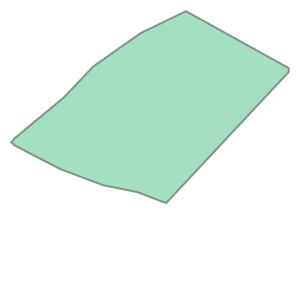

In [ ]:
interpolated_gdf.iloc[2]['geometry']

Save shapefiles as a geojson for interactive plots.

In [ ]:
interpolated_gdf.to_crs(epsg=4326, inplace=True)
interpolated_gdf = interpolated_gdf.sample(frac=1).reset_index(drop=True)

interpolated_stats = './etudiants/'+student_folder+'/USE_CASE_1/interpolated_stats/T31TCJ_median_ndvi_interpolation.geojson'
interpolated_gdf.to_file(interpolated_stats, driver='GeoJSON')

In [ ]:
with open(interpolated_stats) as f:
    parcels = json.load(f)

In [ ]:
type(parcels)

dict

In [ ]:
# ATTENTION : ne pas RUN car 'Output is truncated to 10240000 bytes. Learn more about ZEPPELIN_INTERPRETER_OUTPUT_LIMIT' don't print all dictionnary
# print(parcels)

In [ ]:
# parcels['features'][0]['geometry']['coordinates'][0][0]

In [ ]:
# parcels['features'][0]['properties']

## 🖍 Exercice 3 : PCA
---

### Application de l'ACP

L'ACP est une technique qui vise à trouver les dimensions (composantes principales) qui maximise la variance de l'ensemble de données (structure globale). L'objectif est de réduire la dimension de matrices. Les étapes de l'ACP peuvent être résumées comme suit :

- Normalisez l'ensemble de données en soustrayant la moyenne et en divisant par l'écart type.
- Estimez les valeurs propres et les vecteurs propres à partir de la matrice de covariance ou de la matrice de corrélation.
- Triez les vecteurs propres dans un ordre décroissant en utilisant leurs valeurs propres correspondantes.
- Sélectionnez les vecteurs K avec les valeurs propres les plus élevées.
- Construisez la matrice de projection à partir de ces vecteurs propres.
- Transformez l'ensemble de données normalisé à l'aide de la matrice de projection.

`Consignes :`

1. Etudier la méthode de l'algorithme et l'implémenter en utilisant le langage Python.
2. Etudier les composantes principales




In [ ]:
## A vous de jouer !

In [ ]:
## Collect data
gdf_file = './etudiants/'+student_folder+'/USE_CASE_1/reconstructed_stats/T31TCJ_median_ndvi.shp'
gdf = gpd.read_file(gdf_file)

### Correction 
Une correction avec l'exhaustivité des équations de l'algorithme.

In [ ]:
def pca_classic(Xraw):
    LL = Xraw.shape[1]
    X = (Xraw-np.mean(Xraw,axis=0))/np.std(Xraw,axis=0)
    X = X.T
    
    # Load the feature space
    mean_matrix = np.zeros(X.shape[0],dtype = np.float64)
    
    # Computing the mean
    for d in range (0,X.shape[0]):
        mean_matrix[d] = np.mean(X[d,:])
        
    # Compute the covairance matrix
    cov_mat = np.cov(X)
    # print('Covariance Matrix:\n', cov_mat)
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
    for ev in eig_vec_cov:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
        
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
    
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs = sorted(eig_pairs,key=lambda x:x[0],reverse= True)

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    # for i in eig_pairs:
        # print(i[0])

    matrix_w = np.hstack((eig_pairs[0][1].reshape(LL,1), eig_pairs[1][1].reshape(LL,1)))
    # print('Matrix W:\n', matrix_w)
    matrix_v = np.hstack((eig_pairs[0][1].reshape(LL,1), eig_pairs[1][1].reshape(LL,1),eig_pairs[2][1].reshape(LL,1) ))
    transformed = matrix_w.T.dot(X)
    transformed_v = matrix_v.T.dot(X)
    return transformed_v

gdf_file = './etudiants/'+student_folder+'/USE_CASE_1/reconstructed_stats/T31TCJ_median_ndvi.shp'
gdf = gpd.read_file(gdf_file)

# Select columns
date_cols = gdf.columns[8:-1]
data = gdf[date_cols]

# Apply pca
transformed_data = pca_classic(data.values)
transformed_data = transformed_data.T
transformed_data.shape

(5000, 3)

In [ ]:
fig = px.scatter_3d(x=transformed_data[:,0], y=transformed_data[:,1], z=transformed_data[:,2],
              color=gdf['CODE_CULTU'])
fig.show()

In [ ]:
fig = px.scatter(x=transformed_data[:,0], y=transformed_data[:,1], color=gdf['CODE_CULTU'])
fig.show()

In [ ]:
# l = []
# for i in np.array(gdf['CODE_CULTU']):
#     if i == 'MIS':
#         l.append(0)
#     else:
#         l.append(1)
# print(len(l))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

date_cols = gdf.columns[8:-1]
data_2 = gdf[date_cols]

scaler = StandardScaler()
x = scaler.fit_transform(data_2.values)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

fig = px.scatter_3d(x=principalComponents[:,0], y=principalComponents[:,1], z=principalComponents[:,2],
              color=gdf['CODE_CULTU'])
fig.show()

## 🖍 Exercice 4 : KMeans
---

### Application de l'algorithme KMeans

Etudier la méthode de l'algorithme et l'implémenter en utilisant le langage Python.

Algorithme de clustering non supervisé le plus utilisé, le plus puissant.
Il y a aussi, les algorithmes suivants :
- Hierarchical
- PSO
- Genetic

Pour l'algorithme du KMeans, il faut initialiser certains paramètres :
- K le nombre de clusters
- Les K centres


`Consigne :`

1. Appliquer la méthode du KMeans sur le résultat de l'ACP (qui a permis de réduire la dimension de notre base de données). Appliquer la méthode du KMeans accessible depuis la librairie `sklearn` de Python.
2. Evaluer les résultats à l'aide de la variable `CODE_GROUP`. Utiliser la précision et le rappel.

In [ ]:
## A vous de jouer !

### Correction 
Une correction avec l'exhaustivité des équations de l'algorithme.

3.481003152718004
1.0691271530264612
0.1941747723383138
0.008431737760062211
0.0


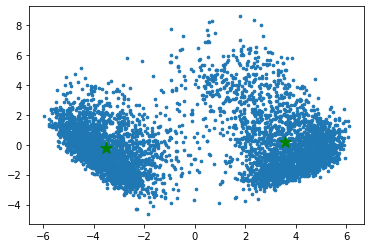

In [ ]:
def kmeans(X,k):
    # Number of training data
    n = X.shape[0]
    # Number of features in the data
    c = X.shape[1]

    # Generate random centers, here we use sigma and mean to ensure it represent the whole data
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    centers = np.random.randn(k,c)*std + mean

    centers_old = np.zeros(centers.shape) # to store old centers
    centers_new = deepcopy(centers) # Store new centers
    clusters = np.zeros(n)
    distances = np.zeros((n,k))

    error = np.linalg.norm(centers_new - centers_old)
    
    # When, after an update, the estimate of that center stays the same, exit loop
    while error != 0:
        # Measure the distance to every center
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - centers_new[i], axis=1)
        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)

        centers_old = deepcopy(centers_new)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            centers_new[i] = np.mean(X[clusters == i], axis=0)
        error = np.linalg.norm(centers_new - centers_old)
        print(error)
      
    # Plot the data and the centers generated as random
    plt.scatter(X[:,0], X[:,1], s=7)
    plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)

    return centers_new,clusters   

centres, clusters = kmeans(transformed_data, 2)

In [ ]:
# Scatter plot with clustering results
fig = px.scatter_3d(x=transformed_data[:,0], y=transformed_data[:,1], z=transformed_data[:,2],
              color=clusters,text=gdf['CODE_GROUP'])
fig.show()

# Légende :
# en couleur les labels
# en chiffre le cluster

In [ ]:
y_true = gdf['CODE_GROUP'].astype(int)-1
y_predict = clusters
y_predict[y_predict==0] = 5
y_predict[y_predict==1] = 0
y_predict[y_predict==5] = 1

accuracy = accuracy_score(y_true,y_predict)
f_score = f1_score(y_true,y_predict)
p_score = precision_score(y_true,y_predict)
r_score = recall_score(y_true,y_predict)

print('Confusion matrix')
print(confusion_matrix(y_true, y_predict))

print('\n', 'accuracy =', accuracy, '\n', 'f_score =', f_score, '\n', 'p_score =', p_score, '\n', 'r_score =', r_score)

Confusion matrix
[[2490   10]
 [  44 2456]]

 accuracy = 0.9892 
 f_score = 0.9891260571888846 
 p_score = 0.9959448499594485 
 r_score = 0.9824


In [ ]:
date_cols = gdf.columns[8:-1]
#data_2 = gdf[date_cols]

scaler = StandardScaler()
data_2 = transformed_data
x = scaler.fit_transform(data_2)

kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
y_pred = kmeans.predict(x)

y_true = gdf['CODE_GROUP'].astype(int)-1
y_predict = y_pred

accuracy = accuracy_score(y_true,y_predict)
f_score = f1_score(y_true,y_predict)
p_score = precision_score(y_true,y_predict)
r_score = recall_score(y_true,y_predict)

print(p_score, '\n', r_score)

0.9971830985915493 
 0.9912


# TP 3 : Supervised Learning

## <u> Objectif : </u>

## - A partir de l'indice de végétation et sachant la classe de chaque parcelle, peut-on prédire la classe de végétation de chaque parcelle ? Un algorithme supervisé est-il plus performant qu'un algorithme non supervisé ?
## - Evaluer les modèles supervisés.

Les algorithmes qui seront analysés sont les suivants : 
- XGBoost
- LSTM (Long Short Term Memory)

L'objectif est d'appliquer des modèles supervisés pour prédire la classe `CODE_GROUP` représentant la culture de chaque parcelle (mais, blé).

## 🌴  Analyse 5 : XGBoost algorithm

Issue de l’algorithme Gradient Boosting

- Bagging (méthode ensembliste parallèle) → combiner les résultats d’un ensemble de modèles afin de fournir une meilleur prédiction
- Boosting (méthode ensembliste séquentielle) → apprentissage en prenant en compte les erreurs de l'itération antérieur (à l’aide de pondération)

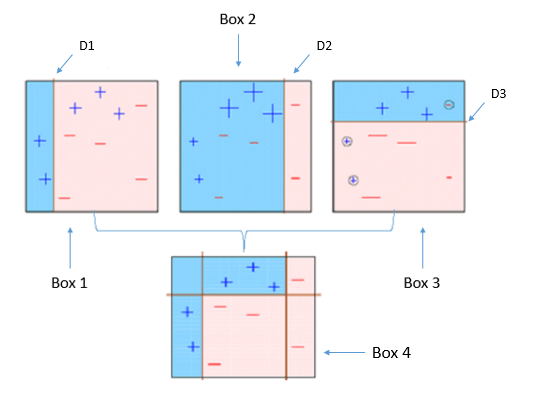

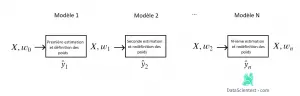

**Description des étapes :**

Ce code démontre les étapes de base pour entraîner et évaluer un modèle XGBoost en Python :

1. Importation des bibliothèques requises : xgboost, pandas, et numpy.
2. Chargement des données dans un DataFrame pandas.
3. Division des données en caractéristiques (X) et cible (y).
4. Division des données en deux ensembles d'apprentissage et de test.
5. Définition des paramètres de XGBoost tels que l'objectif, la profondeur maximale, le taux d'apprentissage et le nombre d'estimateurs.
6. Entraînement du modèle XGBoost.
7. Faire des prédictions sur les données de test.
8. Évaluation des performances du modèle à l'aide de l'erreur quadratique moyenne (RMSE).

In [ ]:
# Load geodataframe
gdf_file = './etudiants/'+student_folder+'/USE_CASE_1/reconstructed_stats/T31TCJ_median_ndvi.shp'
gdf = gpd.read_file(gdf_file)
dates = gdf.columns[8:-1]

# Une line de X est la réponse ndvi d'une parcelle par rapport aux dates 
X = gdf[dates].values
y = (gdf['CODE_GROUP'].values).astype(int)
y = y-1

# Divide dataset into 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #random_state in order to fix the kernel

# Inspect the data
print ('X train shape',X_train.shape)
print ('y train shape',y_train.shape)
print ('unique labels train',np.unique(y_train,return_counts=True))
print ('X test shape',X_test.shape)
print ('y test shape',y_test.shape)
print ('unique labels test',np.unique(y_test,return_counts=True))

# Define the classifer and the evaluation dataset
model = XGBClassifier()
evalset = [(X_train, y_train), (X_test,y_test)]

X train shape (3750, 23)
y train shape (3750,)
unique labels train (array([0, 1]), array([1880, 1870]))
X test shape (1250, 23)
y test shape (1250,)
unique labels test (array([0, 1]), array([620, 630]))


In [ ]:
# Fit the XGBoost model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
# l'erreur sur les données d'apprentissage dans la colonne de gauche
# l'erreur sur les données de test dans la colonne de droite

[0]	validation_0-logloss:0.59913	validation_1-logloss:0.60027
[1]	validation_0-logloss:0.522134	validation_1-logloss:0.524205
[2]	validation_0-logloss:0.457941	validation_1-logloss:0.460888
[3]	validation_0-logloss:0.403628	validation_1-logloss:0.407513
[4]	validation_0-logloss:0.357214	validation_1-logloss:0.36192
[5]	validation_0-logloss:0.31727	validation_1-logloss:0.32278
[6]	validation_0-logloss:0.282572	validation_1-logloss:0.28886
[7]	validation_0-logloss:0.252349	validation_1-logloss:0.259343
[8]	validation_0-logloss:0.225749	validation_1-logloss:0.233541
[9]	validation_0-logloss:0.202319	validation_1-logloss:0.210259
[10]	validation_0-logloss:0.181658	validation_1-logloss:0.190298
[11]	validation_0-logloss:0.163338	validation_1-logloss:0.172047
[12]	validation_0-logloss:0.147083	validation_1-logloss:0.156253
[13]	validation_0-logloss:0.132615	validation_1-logloss:0.141918
[14]	validation_0-logloss:0.119701	validation_1-logloss:0.12972
[15]	validation_0-logloss:0.108179	validat

XGBClassifier()

In [ ]:
# Evaluate model performance
yhat = model.predict(X_test)
yhat_proba = model.predict_proba(X_test) # pour calculer la proba d'appartenance à chaque classe
score = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
f1 = f1_score(y_test, yhat)

print('Accuracy: %.8f' % score)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1, '\n')

print(yhat, '\n',
      np.unique(yhat, return_counts=True), '\n',
      np.unique(y_test, return_counts=True))

Accuracy: 0.99360000
Precision: 0.993651
Recall: 0.993651
F1 score: 0.993651 

[0 0 0 ... 0 0 0] 
 (array([0, 1]), array([620, 630])) 
 (array([0, 1]), array([620, 630]))


✋ Question 4 : 

Qu'est-ce qu'une fonction de perte ? Quelle est la spécificité de la fonction de perte `log-loss` ?

**Réponse :**

Dans le domaine de l’intelligence artificielle, la fonction de perte ou de coût est la quantification de l’écart entre les prévisions du modèle et les observations réelles du jeu de donnée utilisé pendant l’entraînement. La phase d’entraînement vise à trouver les paramètres du modèle qui permettront de minimiser cette fonction.

La perte logarithmique, `log-loss`, indique à quel point la probabilité de prédiction est proche de la valeur réellevraie correspondante (0 ou 1 en cas de classification binaire). Plus la probabilité prédite s'écarte de la valeur réelle, plus la valeur de perte logarithmique est élevée.


\begin{equation*}
L_{log}(y,p) = - (y log(p) + (1-y) log(1-p)) \\ y \in \{0, 1\} \\ p = Pr(y=1)
\end{equation*}


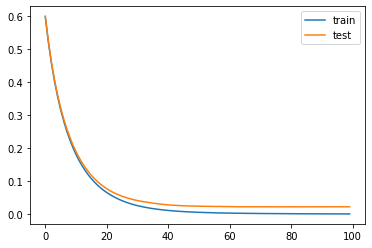

In [ ]:
# Get model performance and plot the loss curves
results = model.evals_result()

# Using matplotlib
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

# L'erreur est plus elevée sur les données de test que sur les données de train

## 🌴  Analyse 6 : XGBoost algorithm parameter tuning : `estimators`

**Conclusion sur le 1er modèle :**
Ce cas d'utilisation ne nécessite pas beaucoup d'ajustement des paramètres car il a déjà donné de bons résultats. 

**Pour la suite :**
Cependant, dans des problèmes de classification plus difficiles, l'ajustement des paramètres peut améliorer les résultats. 

Voici les étapes pratiques pour affiner les paramètres de l'algorithme XGBoost en utilisant les courbes d'apprentissage. 

**Remarque :**
Les courbes d'apprentissage permettent de comprendre l'effet de chaque paramètre sur les performances du modèle. Des méthodes plus automatisées existent, comme la recherche sur grille (`grid search`). Cependant, nous allons ici nous concentrer sur les courbes d'apprentissage pour mieux comprendre le modèle XGBoost.

**1. Increase the number of iterations (estimators)**

[0]	validation_0-logloss:0.59913	validation_1-logloss:0.60027
[1]	validation_0-logloss:0.522134	validation_1-logloss:0.524205
[2]	validation_0-logloss:0.457941	validation_1-logloss:0.460888
[3]	validation_0-logloss:0.403628	validation_1-logloss:0.407513
[4]	validation_0-logloss:0.357214	validation_1-logloss:0.36192
[5]	validation_0-logloss:0.31727	validation_1-logloss:0.32278
[6]	validation_0-logloss:0.282572	validation_1-logloss:0.28886
[7]	validation_0-logloss:0.252349	validation_1-logloss:0.259343
[8]	validation_0-logloss:0.225749	validation_1-logloss:0.233541
[9]	validation_0-logloss:0.202319	validation_1-logloss:0.210259
[10]	validation_0-logloss:0.181658	validation_1-logloss:0.190298
[11]	validation_0-logloss:0.163338	validation_1-logloss:0.172047
[12]	validation_0-logloss:0.147083	validation_1-logloss:0.156253
[13]	validation_0-logloss:0.132615	validation_1-logloss:0.141918
[14]	validation_0-logloss:0.119701	validation_1-logloss:0.12972
[15]	validation_0-logloss:0.108179	validat

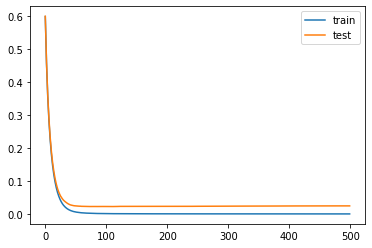

In [ ]:
model = XGBClassifier(n_estimators=500)
evalset = [(X_train, y_train), (X_test,y_test)]
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

# Evaluate model performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
f1 = f1_score(y_test, yhat)
print('Accuracy: %.8f' % score)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1, '\n')
results = model.evals_result()

# Using matplotlib
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

Les courbes descendent très vite, l'algorithme apprend très vite ça veut dire.
On va alors diminuer la vitesse d'apprentissage de l'algorithme.
Car sinon on risque de faire du sur-apprentissage.

On va utiliser le 'learning_rate'.
Plus ce coefficient est petit, plus le modèle va prendre son temps dans l'apprentissage.

## 🌴  Analyse 7 : XGBoost algorithm parameter tuning : `learning rate`

**Conclusion sur le 2nd modèle :**
De longues courbes plates peuvent indiquer que l'algorithme apprend trop vite. 

**Pour la suite :**
Nous pouvons ralentir la vitesse d'apprentissage en diminuant le taux d'apprentissage. Le taux d'apprentissage limite la contribution de chaque arbre à l'ensemble.

**2. Decreasing the learning rate**

[0]	validation_0-logloss:0.59913	validation_1-logloss:0.60027
[1]	validation_0-logloss:0.522134	validation_1-logloss:0.524205
[2]	validation_0-logloss:0.457941	validation_1-logloss:0.460888
[3]	validation_0-logloss:0.403628	validation_1-logloss:0.407513
[4]	validation_0-logloss:0.357214	validation_1-logloss:0.36192
[5]	validation_0-logloss:0.31727	validation_1-logloss:0.32278
[6]	validation_0-logloss:0.282572	validation_1-logloss:0.28886
[7]	validation_0-logloss:0.252349	validation_1-logloss:0.259343
[8]	validation_0-logloss:0.225749	validation_1-logloss:0.233541
[9]	validation_0-logloss:0.202319	validation_1-logloss:0.210259
[10]	validation_0-logloss:0.181658	validation_1-logloss:0.190298
[11]	validation_0-logloss:0.163338	validation_1-logloss:0.172047
[12]	validation_0-logloss:0.147083	validation_1-logloss:0.156253
[13]	validation_0-logloss:0.132615	validation_1-logloss:0.141918
[14]	validation_0-logloss:0.119701	validation_1-logloss:0.12972
[15]	validation_0-logloss:0.108179	validat

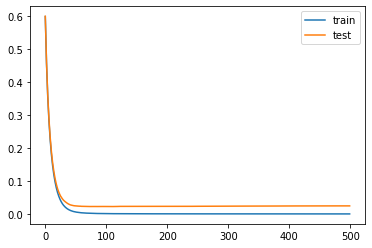

In [ ]:
model = XGBClassifier(n_estimators=500, eta=0.05)
evalset = [(X_train, y_train), (X_test,y_test)]
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

# Evaluate model performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
f1 = f1_score(y_test, yhat)
print('Accuracy: %.8f' % score)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1, '\n')
results = model.evals_result()

# Using matplotlib
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

Quand on fait du parametrage manuellement, une méthode est de suivre les étapes suivantes :
1. ajuster le nombre de modèles
2. ajuster le learning rate
3. réajuster à nouveau le nombre d'estimateurs (ie. de modèles)

## 🌴  Analyse 8 : XGBoost algorithm parameter tuning : `estimators`

**Conclusion sur le 3ème modèle :**
Nous pouvons voir que la performance est toujours la même en augmentant les itérations et en diminuant le taux d'apprentissage.

**Pour la suite :**
Essayons d'augmenter le nombre d'itérations à 2000.

[0]	validation_0-logloss:0.59913	validation_1-logloss:0.60027
[1]	validation_0-logloss:0.522134	validation_1-logloss:0.524205
[2]	validation_0-logloss:0.457941	validation_1-logloss:0.460888
[3]	validation_0-logloss:0.403628	validation_1-logloss:0.407513
[4]	validation_0-logloss:0.357214	validation_1-logloss:0.36192
[5]	validation_0-logloss:0.31727	validation_1-logloss:0.32278
[6]	validation_0-logloss:0.282572	validation_1-logloss:0.28886
[7]	validation_0-logloss:0.252349	validation_1-logloss:0.259343
[8]	validation_0-logloss:0.225749	validation_1-logloss:0.233541
[9]	validation_0-logloss:0.202319	validation_1-logloss:0.210259
[10]	validation_0-logloss:0.181658	validation_1-logloss:0.190298
[11]	validation_0-logloss:0.163338	validation_1-logloss:0.172047
[12]	validation_0-logloss:0.147083	validation_1-logloss:0.156253
[13]	validation_0-logloss:0.132615	validation_1-logloss:0.141918
[14]	validation_0-logloss:0.119701	validation_1-logloss:0.12972
[15]	validation_0-logloss:0.108179	validat

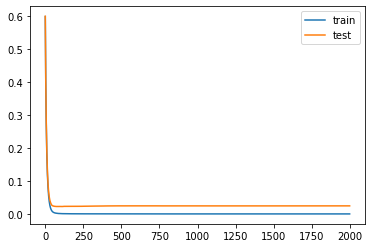

In [ ]:
model = XGBClassifier(n_estimators=2000, eta=0.05)
evalset = [(X_train, y_train), (X_test,y_test)]
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

# Evaluate model performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
f1 = f1_score(y_test, yhat)
print('Accuracy: %.8f' % score)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1, '\n')
results = model.evals_result()

# Using matplotlib
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

## 🌴  Analyse 9 : XGBoost algorithm parameter tuning : `subsample` and `colsample_bytree`

**Conclusions :**
Nous sommes arrivés à des résultats similaires à ceux de la configuration initiale. Augmenter le nombre d'itérations et diminuer le taux d'apprentissage est un bon début pour optimiser les paramètres du XGBoost. Ce processus peut être effectué plusieurs fois

**Pour la suite :**
Pour généraliser les modèles, et ajouter plus de robustesse, les derniers parametres que nous allons ajuster sont :

- subsample : choix d'un pourcentage des données de l'ensemble d'entraînement qui seront sélectionnées à chaque itération (on va sélectionner uniquement 50% des données d'entraînement par exemple) --> sous-échantillonnage à chaque itération du boosting

- colsample_bytree : on va choisir aléatoirement un nb de features (choix d'un pourcentage de variables, de colonnes, qui seront sélectionnés à chaque itération) --> sous-échantillonnage des colonnes lors de la construction de chaque arbre de décision.

**3. Reguralization using the number of samples and feature used to construct the trees**

[0]	validation_0-logloss:0.64534	validation_1-logloss:0.645873
[1]	validation_0-logloss:0.601968	validation_1-logloss:0.602648
[2]	validation_0-logloss:0.562355	validation_1-logloss:0.563272
[3]	validation_0-logloss:0.526293	validation_1-logloss:0.527578
[4]	validation_0-logloss:0.493265	validation_1-logloss:0.49484
[5]	validation_0-logloss:0.462983	validation_1-logloss:0.464881
[6]	validation_0-logloss:0.434879	validation_1-logloss:0.437246
[7]	validation_0-logloss:0.408883	validation_1-logloss:0.411106
[8]	validation_0-logloss:0.384904	validation_1-logloss:0.387416
[9]	validation_0-logloss:0.362571	validation_1-logloss:0.365327
[10]	validation_0-logloss:0.341909	validation_1-logloss:0.344834
[11]	validation_0-logloss:0.322625	validation_1-logloss:0.32563
[12]	validation_0-logloss:0.304709	validation_1-logloss:0.307836
[13]	validation_0-logloss:0.287749	validation_1-logloss:0.29116
[14]	validation_0-logloss:0.272097	validation_1-logloss:0.275701
[15]	validation_0-logloss:0.257306	vali

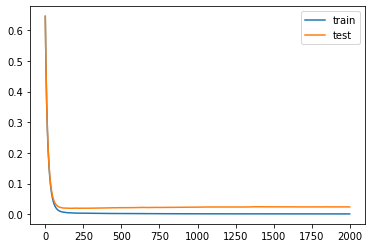

In [ ]:
model = XGBClassifier(n_estimators=2000, eta=0.05, subsample=0.5, colsample_bytree=0.5)
evalset = [(X_train, y_train), (X_test,y_test)]
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)

# Evaluate model performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)
f1 = f1_score(y_test, yhat)
print('Accuracy: %.8f' % score)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1, '\n')
results = model.evals_result()

# Using matplotlib
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

On a amélioré la courbe de la fonction de perte `logloss`.

### Now that we are happy with the results, let's calculate all the evaluation metrics we learned before

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test,yhat)
f_score = f1_score(y_test,yhat)
p_score = precision_score(y_test,yhat)
r_score = recall_score(y_test,yhat)
confusion_mat = confusion_matrix(y_test,yhat)

print ('accuracy',accuracy)
print ('f1 score',f_score)
print ('precision',p_score)
print ('recall',r_score)
print ('confusion matrix',confusion_mat)

accuracy 0.9944
f1 score 0.9944311853619731
precision 0.9968102073365231
recall 0.9920634920634921
confusion matrix [[618   2]
 [  5 625]]


In [ ]:
# or we can get a classification repot using sklearn
from sklearn.metrics import classification_report
report = classification_report(y_test,yhat)
report

'              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99       620\n           1       1.00      0.99      0.99       630\n\n    accuracy                           0.99      1250\n   macro avg       0.99      0.99      0.99      1250\nweighted avg       0.99      0.99      0.99      1250\n'

### The XGBoost algorithm allows us to visualize the feature importance, i.e., a score associated with each input feature that reflects its importance in making the decision function

Importance de features. IA explicable (on va essayer de comprendre avec le feature qu'on prend comment le modèle a pensé).

<BarContainer object of 23 artists>

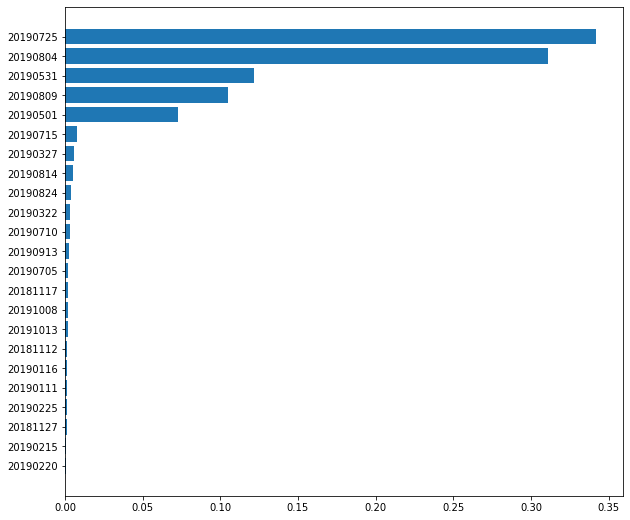

In [ ]:
importance = model.feature_importances_
sorted_idx = importance.argsort()
plt.figure(figsize=(10,9))
plt.barh(dates[sorted_idx], importance[sorted_idx])

## Discussion en fonction des dates et de leur importance dans la détermination des sols (blé ou maïs)

## Commentaires
## Ici représentation de l'importance en magnitude (comment le feature a influencé)
# on ne sait pas positivement ou negativement
# ni pour quel classe

## 🖍 Exercice 4 : Long Short Term Memory algorithm (LSTM)
---

L'algorithme LSTM est adapté adapté pour la prédiction temporelle ou tout autre problème nécessitant une "mémorisation" du passé. Il s'applique donc pour des cas de séries temporelles (comme dans notre cas d'utilisation). Il peut également gérer les données manquantes sans avoir besoin de reconstruction ou d'interpolation.



`Consignes :`

1. Préparer les données en sélectionnant uniquement les colonnes contenant les mesures des ndvi par date. Transformer le tableau en matrice.
2. Remplacer les valeurs manquantes par le chiffre "2", afin de les indiquer à l'algorithme.
3. Préparer les données en les divisant en séquences d'entraînement et de test.
4. Définir le modèle LSTM en spécifiant le masque des valeurs manquantes, le nombre de couches et le nombre de neurones par couche.
5. Compiler le modèle en définissant la fonction de coût et l'optimiseur.
6. Entraîner le modèle sur les données d'entraînement en spécifiant le nombre d'époques et la taille du lot.
7. Evaluer le modèle sur les données de test en utilisant une métrique appropriée (par exemple : la précision, le rappel, RMSE pour le cas de régression, etc.)
8. Analyser les résultats et affiner le modèle si nécessaire en ajustant les hyperparamètres, en changeant la structure du réseau, etc.

In [ ]:
# Let's get our data without interpolation but we have to specify where are the missing values
gdf_file = './etudiants/'+student_folder+'/USE_CASE_1/cleaned_stats/T31TCJ_median_ndvi.shp'
gdf = gpd.read_file(gdf_file)


**N.B. :** Note that by fixing the random state of the train_test_split, we have the same exact training and testing dataset as in the XGBoost, except that the data here has missing values

### Correction 

2956
0
X train shape (3750, 23)
y train shape (3750,)
unique labels train (array([0, 1]), array([1880, 1870]))
X test shape (1250, 23)
y test shape (1250,)
unique labels test (array([0, 1]), array([620, 630]))
Epoch 1/10
116/118 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.9461
Epoch 1: saving model to ./LSTM_WEIGHTS/weights-01-0.19.hdf5
118/118 [==============================] - 15s 45ms/step - loss: 0.1899 - accuracy: 0.9467 - val_loss: 0.0411 - val_accuracy: 0.9864
Epoch 2/10
117/118 [============================>.] - ETA: 0s - loss: 0.0356 - accuracy: 0.9909
Epoch 2: saving model to ./LSTM_WEIGHTS/weights-02-0.04.hdf5
118/118 [==============================] - 3s 29ms/step - loss: 0.0356 - accuracy: 0.9909 - val_loss: 0.0398 - val_accuracy: 0.9920
Epoch 3/10
117/118 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9907
Epoch 3: saving model to ./LSTM_WEIGHTS/weights-03-0.03.hdf5
118/118 [==============================] - 3s 29ms/ste

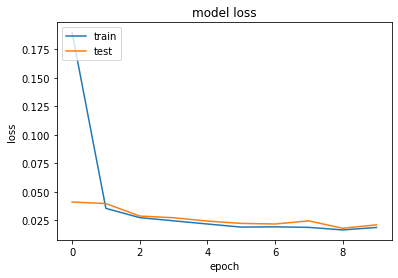

In [ ]:
########################################
##           Data preparation         ##
########################################

# Let's get our data without interpolation but we have to specify where are the missing values
gdf_file = './etudiants/'+student_folder+'/USE_CASE_1/cleaned_stats/T31TCJ_median_ndvi.shp'
gdf = gpd.read_file(gdf_file)
dates = gdf.columns[8:-1]
X = gdf[dates].values
y = (gdf['CODE_GROUP'].values).astype(int)
y = y-1
print (np.isnan(X).sum())

# Let's first replace our nans with a value to indicate them for the algorithm
X[np.isnan(X)]=-2

# Now let's see if we still have nans or not 
print(np.isnan(X).sum())

# Divide our dataset into 75% train and 25% test and then inspect the shapes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Print information
print ('X train shape',X_train.shape)
print ('y train shape',y_train.shape)
print ('unique labels train',np.unique(y_train,return_counts=True))
print ('X test shape',X_test.shape)
print ('y test shape',y_test.shape)
print ('unique labels test',np.unique(y_test,return_counts=True))

########################################
##         Input data settings        ##
########################################

x_shape = X_train.shape[1]
y_shape = 1
n_class = 2

########################################
##           Model settings           ##
########################################

model = Sequential()
model.add(Masking(mask_value=-2, input_shape=(x_shape, y_shape)))
model.add(LSTM(100)) # il y a 100 number samples
model.add(Dense(n_class, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # also loss='binary_crossentropy'

# One hot encoding of the labels
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

# Transform X to 3D (samples,time steps,features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

########################################
##             Training               ##
########################################

# Define a path to store the models at each iteration
filepath='./LSTM_WEIGHTS/weights-{epoch:02d}-{loss:.2f}.hdf5'

# Define the model checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,save_best_only=False)
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=10, shuffle = True, batch_size=32, callbacks=callbacks_list, validation_data=(X_test, y_test))

########################################
##           Loss function            ##
########################################

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

########################################
##        Statistical results         ##
########################################

#yhat = model.predict_classes(X_test)
yhat = model.predict(X_test).round()
y1 = y_test.astype(int) 
accuracy = accuracy_score(y_test[:,1], yhat[:,1], normalize=False)
f_score = f1_score(y_test[:,1], yhat[:,1])
p_score = precision_score(y_test[:,1], yhat[:,1])
r_score = recall_score(y_test[:,1], yhat[:,1])
confusion_mat = confusion_matrix(y_test[:,1], yhat[:,1])

print ('accuracy',accuracy)
print ('f1 score',f_score)
print ('precision',p_score)
print ('recall',r_score)
print ('confusion matrix',confusion_mat)